In [1]:
import pandas as pd 
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


from sklearn.model_selection import cross_val_score


from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
    
import warnings
warnings.filterwarnings('ignore')

In [68]:
# указать свой путь до файла
df = pd.read_excel(r'C:\Users\user\Interviews\Тестовое задание junior\Тестовое задание по банкам\BST_DataSet.xlsx', index_col = 0)

In [52]:
df = df.reset_index().rename(columns={'index':'date'})

### Проверка пропусков

In [53]:
df.isna().sum()
# 12 значений, которые предстоит предсказать

date                                                  0
Прирост вкладов физических лиц в рублях (млн руб)    12
Доходность ОФЗ по сроку до 1 года                     0
Ключевая ставка                                       0
Ставка по вкладам в долларах до 1 года                0
Ставка по вкладам в рублях до 1 года                  0
Нефть марки Юралс, долл./барр                         0
Индекс потребительских цен, ед.                       0
М0, руб                                               0
М2, руб                                               0
Курс доллара к рублю, руб                             0
Номинальная средняя з/п, руб                          0
dtype: int64

### Создадим новые переменные

In [54]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
year_replace = {}
for i, year in enumerate(df['year'].unique()):
      year_replace[year] = i
month_replace = {}
for i, month in enumerate(df['month'].unique()):
      month_replace[month] = i
df['month'].replace(month_replace, inplace=True)
df['year'].replace(year_replace, inplace=True)
df['trend'] = [year*12 + (month+1) for year, month in zip(df.year, df.month)]
df['2014'] = [1 if year >= 3 else 0 for year in df['year']]

In [55]:
# оставим только те данные, по которым известны предсказания
df_1 = df[df.date < '01.01.2017']
df_2 = df[df.date >= '01.01.2017']

### Создание класса

Давайте создадим класс, который реализует следующий функционал: 
1. Инициализирует наши данные
2. Проводит разведочный анализ данных
3. Строит линейные модели (Линейная регрессия, Ridge регрессия, Lasso регрессия)
4. Строит деревья ( Дерево решений)
5. Строит SARIMA, SARIMAX модели
6. Считает ошибки прогнозов по трем метрикам (RMSE, MSE, MAE)
7. Выбирает лучшую модель

In [64]:
class Modelbank():
    def __init__(self, dataframe, train_ratio=0.9, regularization:bool=True, 
                 independent_categorical_variable:list = [], independent_numeric_variable:list=[], target = [], dataframe_predict = None):
        self.df = dataframe
        self.train_ratio = train_ratio
        self.regularization = regularization
        self.independent_categorical_variable = independent_categorical_variable
        self.independent_numeric_variable = independent_numeric_variable
        self.all_features = independent_categorical_variable + independent_numeric_variable
        self.target = target
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.df[self.all_features], self.df[self.target], train_size=self.train_ratio, random_state=10) 
        
        self.dataframe_predict = dataframe_predict
        # проверки 
        for ind_variable in self.independent_numeric_variable:
            if ind_variable not in list(self.df.columns):
                raise ValueError('Данных числовых переменных нет в данных')
        for cat_variable in self.independent_categorical_variable:
            if cat_variable not in list(self.df.columns):
                raise ValueError('Данных категориальных переменных нет в данных')
        if self.target not in list(self.df.columns):
            raise ValueError('Данного таргета нет в данных')
            
        self.rmse = []
        self.model = []
            
    def exploratory_analysis(self, ):
        print('Описательные статистики')
        print(self.df[self.all_features].describe())
        
        
        sns.distplot(self.df[self.target])
        plt.title('Распределение таргета')
        plt.show()
        
        self.df[self.target].plot()
        plt.title('Изменение динамики таргета')
        plt.xlabel('Месяц')
        plt.ylabel(str(self.target))
        plt.show()
        
        correlation = self.df[self.all_features].corr()
        plt.figure(figsize=(15,15))
        sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')
        plt.title('Матрица корреляции', fontdict = {'fontsize' : 15})
        plt.show()
        
            
    def linear_regression(self, ):
        column_transformer = ColumnTransformer([
            ('ohe', OneHotEncoder(handle_unknown="ignore"), self.independent_categorical_variable),
            ('scaling', StandardScaler(), self.independent_numeric_variable)
        ])
        self.pipeline_linear = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', LinearRegression())
            ])
        model = self.pipeline_linear.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)
        
        coefficient = pd.DataFrame(model.named_steps['regression'].coef_,[j.split('__')[1] for j in model[:-1].get_feature_names_out()], columns=['Coefficients'])
        
        self.feature_name = [j.split('__')[1] for j in model[:-1].get_feature_names_out()]
        print('Резульататы линейной модели:')
        print('Test MAE = %.4f' % mean_absolute_error(self.y_test, y_pred))
        print('Test MSE = %.4f' %  mean_squared_error(self.y_test, y_pred))
        print("Test RMSE = %.4f" % mean_squared_error(self.y_test, y_pred, squared=False))
        print('Значение коэффициентов:')
        plt.figure(figsize=(7,7))
        plt.xticks(rotation=90)
        sns.barplot(x=coefficient.index, y=coefficient.Coefficients)
        plt.xlabel('Features', fontsize=15)
        plt.show()
        
        self.rmse.append(mean_squared_error(self.y_test, y_pred, squared=False))
        self.model.append('linear_regression')
        
        if self.regularization:
                    alphas = np.logspace(0, 2, 10)
                    searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
                    searcher.fit(self.X_train, self.y_train)
                    best_alpha = searcher.best_params_["alpha"]
                    column_transformer = ColumnTransformer([
                        ('ohe', OneHotEncoder(handle_unknown="ignore"), self.independent_categorical_variable),
                        ('scaling', StandardScaler(), self.independent_numeric_variable)])
                    self.pipeline_Ridge = Pipeline(steps=[
                    ('ohe_and_scaling', column_transformer),
                    ('regression', Ridge(best_alpha))
                            ])
                    model = self.pipeline_Ridge.fit(self.X_train, self.y_train)
                    y_pred = model.predict(self.X_test)
                    
                    coefficient = pd.DataFrame(model.named_steps['regression'].coef_,[j.split('__')[1] for j in model[:-1].get_feature_names_out()], columns=['Coefficients'])
                    print(f'Параметры Ridge: {best_alpha}')
                    print('Резульат Ridge модели: ')
                    print('Test MAE = %.4f' % mean_absolute_error(self.y_test, y_pred))
                    print('Test MSE = %.4f' %  mean_squared_error(self.y_test, y_pred))
                    print("Test RMSE = %.4f" % mean_squared_error(self.y_test, y_pred, squared=False))
                    print('Значение коэффициентов:')
                    plt.figure(figsize=(7,7))
                    plt.xticks(rotation=90)
                    sns.barplot(x=coefficient.index, y=coefficient.Coefficients)
                    plt.xlabel('Features', fontsize=15)
                    plt.show()
                    
                    self.rmse.append(mean_squared_error(self.y_test, y_pred, squared=False))
                    self.model.append('ridge_regression')

                    
                    searcher = GridSearchCV(Lasso(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
                    searcher.fit(self.X_train, self.y_train)
                    best_alpha = searcher.best_params_["alpha"]
                    self.pipeline_lasso = Pipeline(steps=[
                    ('ohe_and_scaling', column_transformer),
                    ('regression', Lasso(best_alpha))])
                    
                    model = self.pipeline_lasso.fit(self.X_train, self.y_train)
                    y_pred = model.predict(self.X_test)
                    
                    coefficient = pd.DataFrame(model.named_steps['regression'].coef_,[j.split('__')[1] for j in model[:-1].get_feature_names_out()], columns=['Coefficients'])
                    print(f'Параметры Lasso: {best_alpha}')
                    print('Резульат Lasso модели: ')
                    print('Test MAE = %.4f' % mean_absolute_error(self.y_test, y_pred))
                    print('Test MSE = %.4f' %  mean_squared_error(self.y_test, y_pred))
                    print("Test RMSE = %.4f" % mean_squared_error(self.y_test, y_pred, squared=False))
                    print('Значение коэффициентов:')
                    plt.figure(figsize=(7,7))
                    plt.xticks(rotation=90)
                    sns.barplot(x=coefficient.index, y=coefficient.Coefficients)
                    plt.xlabel('Features', fontsize=15)
                    plt.show()            
                    
                    self.rmse.append(mean_squared_error(self.y_test, y_pred, squared=False))
                    self.model.append('lasso_regression')
    def trees(self, ):
        tree_param = {'max_depth':[4,5,6,7,8,9,10]}
        searcher = GridSearchCV(DecisionTreeRegressor(), tree_param, cv=10)
        searcher.fit(self.X_train, self.y_train)
        best_depth = searcher.best_params_['max_depth']
        column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), self.independent_categorical_variable),
    ('scaling', StandardScaler(), self.independent_numeric_variable)])
        self.pipeline_trees = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('trees', DecisionTreeRegressor(max_depth=best_depth))
            ])
        model = self.pipeline_trees.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)

        coefficient = pd.DataFrame(model['trees'].feature_importances_,self.feature_name, columns=['Coefficients'])
        print('Результаты дерева решений:')
        print('Test MAE = %.4f' % mean_absolute_error(self.y_test, y_pred))
        print('Test MSE = %.4f' %  mean_squared_error(self.y_test, y_pred))
        print("Test RMSE = %.4f" % mean_squared_error(self.y_test, y_pred, squared=False))
        print('Значение коэффициентов:')
        plt.figure(figsize=(7,7))
        plt.xticks(rotation=90)
        sns.barplot(x=coefficient.index, y=coefficient.Coefficients)
        plt.xlabel('Features', fontsize=15)
        plt.show()
        
        print('Выбор модели:')
        plt.figure(figsize=(35, 35))
        _ = tree.plot_tree(model['trees'], 
                   feature_names=self.feature_name,  
                   class_names=self.target,
                   filled=True)
        plt.show()
        
        self.rmse.append(mean_squared_error(self.y_test, y_pred, squared=False))
        self.model.append('trees')
    
    def sarima(self, ):
        X_train, X_test= self.df.iloc[0:int(self.df.shape[0] * self.train_ratio), :][self.all_features],\
        self.df.iloc[int(self.df.shape[0] * 0.9):, :][self.all_features]
        y_train, y_test = self.df.iloc[0:int(self.df.shape[0] * self.train_ratio), :][self.target],\
        self.df.iloc[int(self.df.shape[0] * 0.9):, :][self.target]
        
        self.arima = auto_arima(y_train,  start_P=0, start_Q=0, max_P=2, max_Q=2, m=12, seasonal=True)
        y_pred = self.arima.predict(y_test.shape[0])

        print('Результат подбора аримы модели: ')
        print(f"Порядок :{self.arima}")
        order = self.arima.order
        seasonal_order = self.arima.seasonal_order
        print('Test MAE = %.4f' % mean_absolute_error(y_test, y_pred))
        print('Test MSE = %.4f' %  mean_squared_error(y_test, y_pred))
        print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
        self.rmse.append(mean_squared_error(y_test, y_pred, squared=False))
        self.model.append('SARIMA')
        print('Результат подбор SARIMAX модели:')
        self.Sarimax = SARIMAX(y_train, X_train,order=order, seasonal_order=seasonal_order).fit()
        print(self.Sarimax.summary())
        self.Sarimax.plot_diagnostics(figsize=(18, 8))
        plt.show()
        y_pred = self.Sarimax.get_forecast(steps = y_test.shape[0], exog=X_test).predicted_mean
        print('Test MAE = %.4f' % mean_absolute_error(y_test, y_pred))
        print('Test MSE = %.4f' %  mean_squared_error(y_test, y_pred))
        print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
        self.rmse.append(mean_squared_error(y_test, y_pred, squared=False))
        self.model.append('SARIMAX')
        
    def choose_best_model(self):
        self.statistic = pd.DataFrame(self.rmse, self.model, columns=['RMSE']).reset_index().rename(columns={'index':'model'})
        print('Таблица метрик')
        print(self.statistic)
        self.index = np.argmin(self.statistic["RMSE"])
        print(f'Лучшая модель: {self.statistic["model"][self.index]}, ее ошибка: {self.statistic["RMSE"][self.index]}')
    
    def predict(self, to_csv=True):
        models = [self.pipeline_linear, self.pipeline_Ridge, self.pipeline_lasso, self.pipeline_trees]
        if self.index <=3:
            y_pred = models[self.index].fit(self.df[self.all_features], self.df[self.target]).predict(self.dataframe_predict[self.all_features])
            print('Прогноз неизвестных значений:')
            print(y_pred)
            if to_csv:
                self.dataframe_predict[self.target] = y_pred
                self.dataframe_predict.to_csv(f'Predict_{self.target}.csv', encoding='utf-32')
            
        elif self.index == 4:
            self.arima = auto_arima(self.dataframe[self.target],  start_P=0, start_Q=0, max_P=2, max_Q=2, m=12, seasonal=True)
            y_pred = arima.predict(self.dataframe_predict.shape[0])
            print('Прогноз неизвестных значений:')
            print(y_pred)
            if to_csv:
                self.dataframe_predict[self.target] = y_pred
                self.dataframe_predict.to_csv(f'Predict_{self.target}.csv', encoding='utf-32')
        else:
            self.arima = auto_arima(self.dataframe[self.target],  start_P=0, start_Q=0, max_P=2, max_Q=2, m=12, seasonal=True)
            order = self.arima.order
            seasonal_order = self.arima.seasonal_order
            Sarimax = SARIMAX(self.dataframe[self.target], self.dataframe[self.all_features],order=order, seasonal_order=seasonal_order).fit()
            y_pred = Sarimax.get_forecast(steps = self.dataframe_predict.shape[0], exog=self.dataframe_predict[self.all_features]).predicted_mean
            print('Прогноз неизвестных значений:')
            print(y_pred)
            if to_csv:
                self.dataframe_predict[self.target] = y_pred
                self.dataframe_predict.to_csv(f'Predict_{self.target}.csv', encoding='utf-32')
            

        
        
        
    
        
        

Описательные статистики
           month       2014  Доходность ОФЗ по сроку до 1 года  \
count  72.000000  72.000000                          72.000000   
mean    5.500000   0.500000                           7.845004   
std     3.476278   0.503509                           2.359552   
min     0.000000   0.000000                           4.558571   
25%     2.750000   0.000000                           6.135143   
50%     5.500000   0.500000                           6.547364   
75%     8.250000   1.000000                           9.630476   
max    11.000000   1.000000                          15.098421   

       Ключевая ставка  Ставка по вкладам в долларах до 1 года  \
count        72.000000                               72.000000   
mean          9.145833                                2.432361   
std           2.375695                                1.000053   
min           5.500000                                0.710000   
25%           8.000000                             

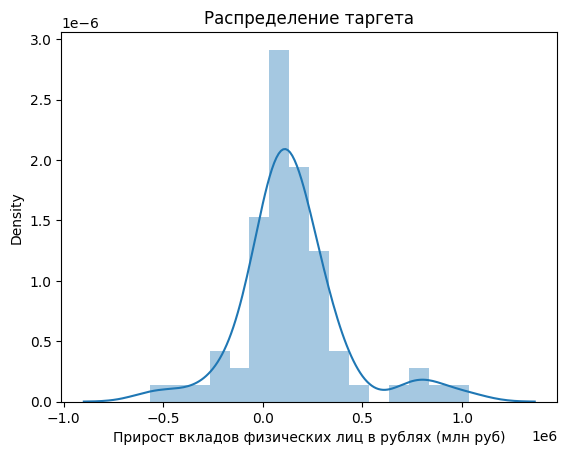

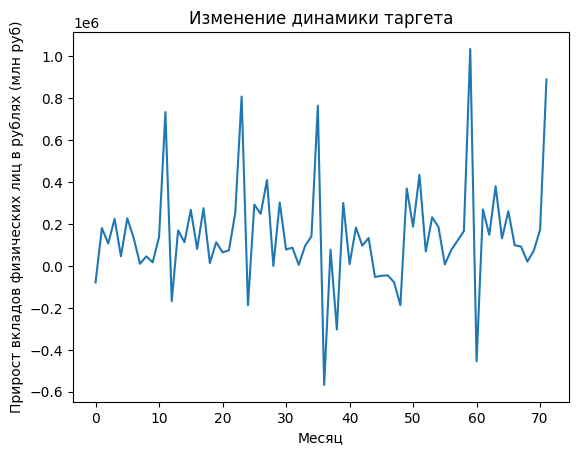

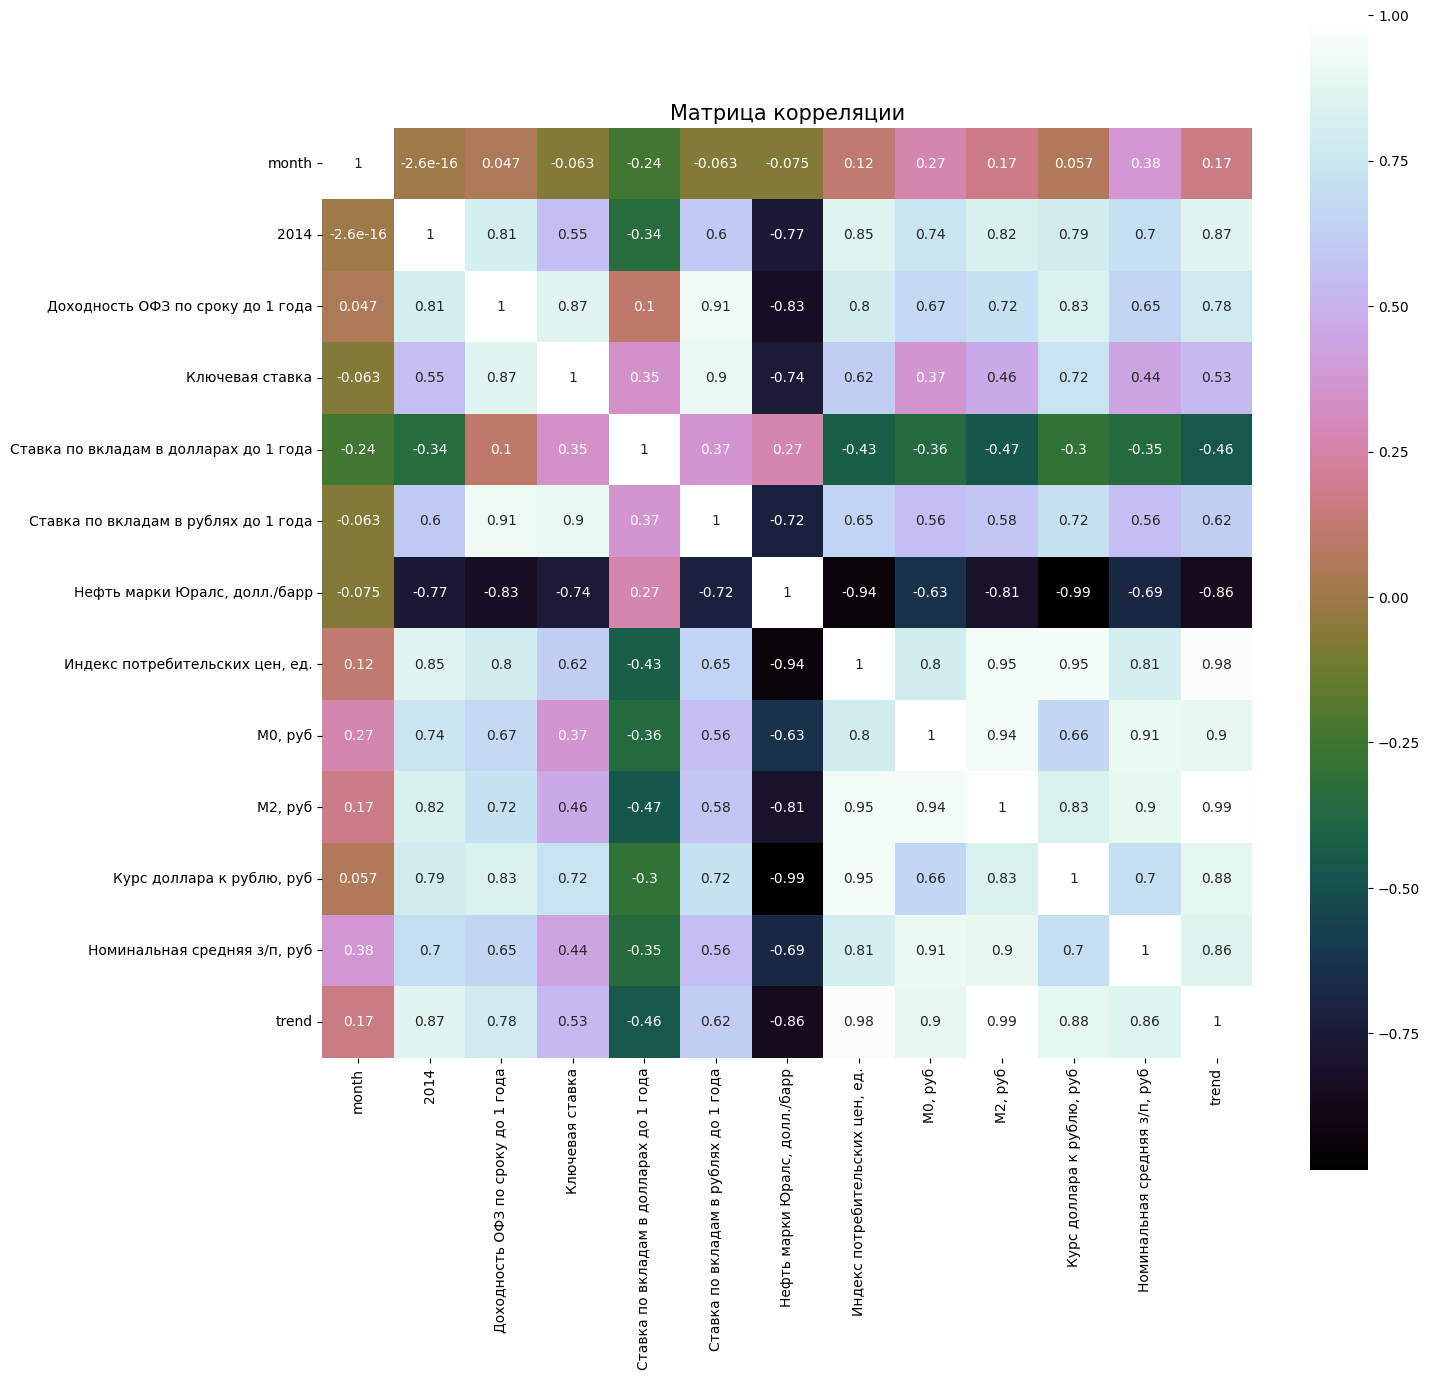

Резульататы линейной модели:
Test MAE = 111360.3445
Test MSE = 15315193128.8352
Test RMSE = 123754.5681
Значение коэффициентов:


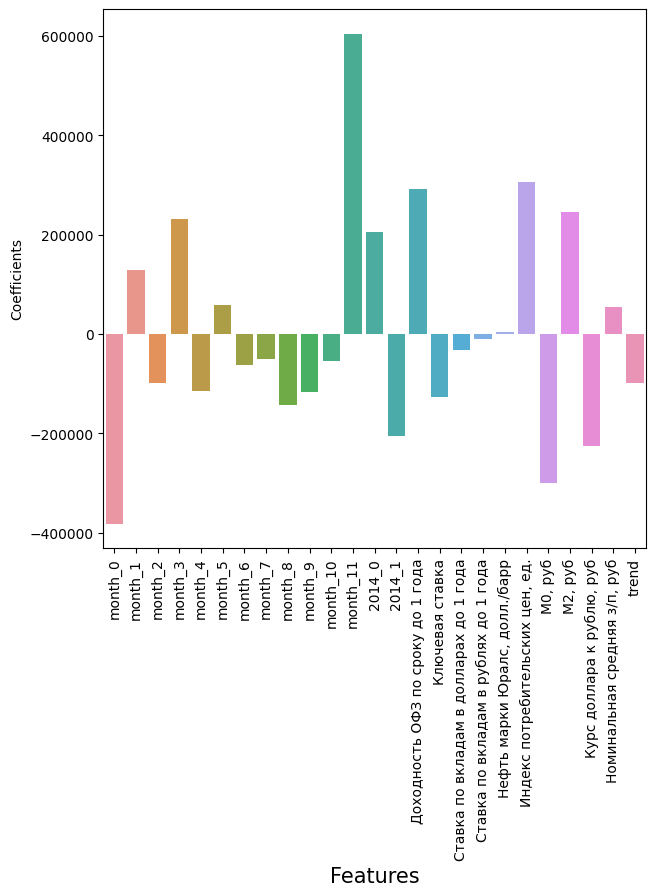

Параметры Ridge: 100.0
Резульат Ridge модели: 
Test MAE = 85424.1042
Test MSE = 9563891539.0922
Test RMSE = 97795.1509
Значение коэффициентов:


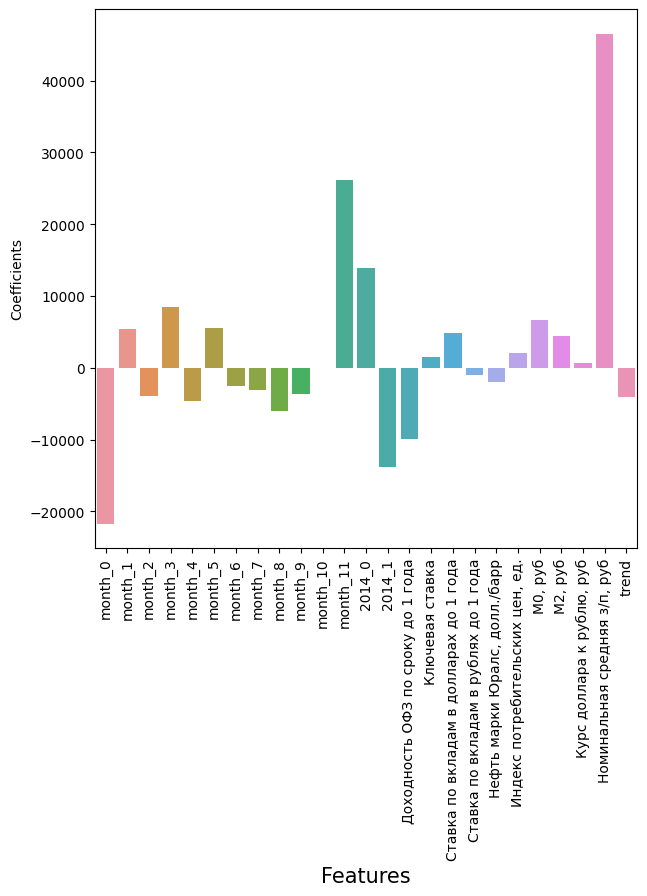

Параметры Lasso: 100.0
Резульат Lasso модели: 
Test MAE = 107837.1664
Test MSE = 14403982567.7339
Test RMSE = 120016.5929
Значение коэффициентов:


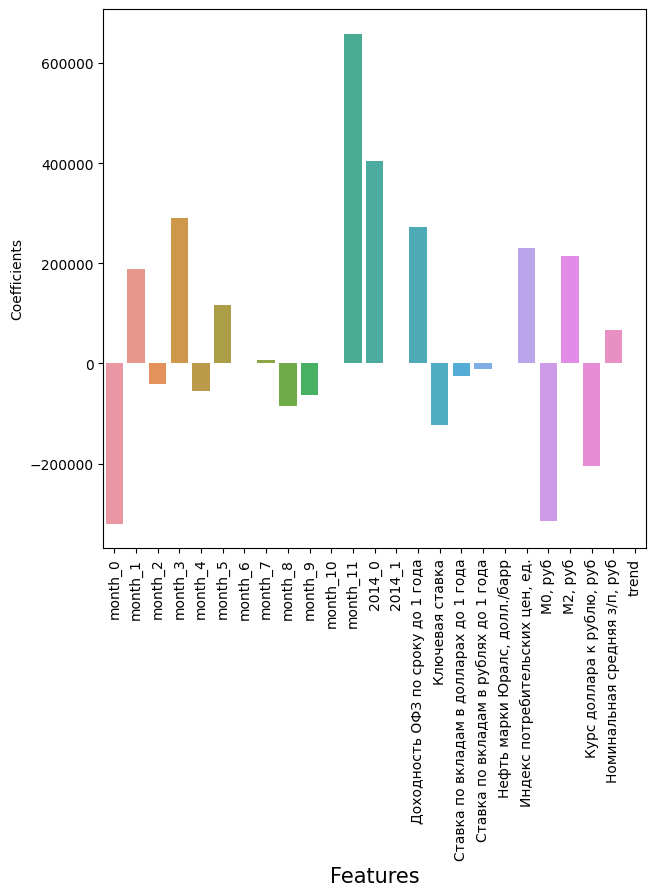

Результаты дерева решений:
Test MAE = 75577.8631
Test MSE = 9615239343.5897
Test RMSE = 98057.3268
Значение коэффициентов:


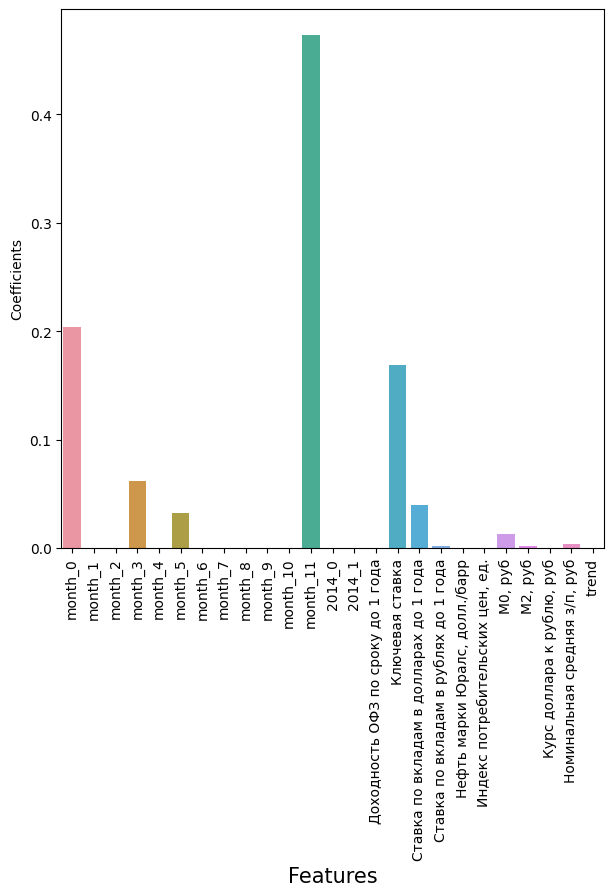

Выбор модели:


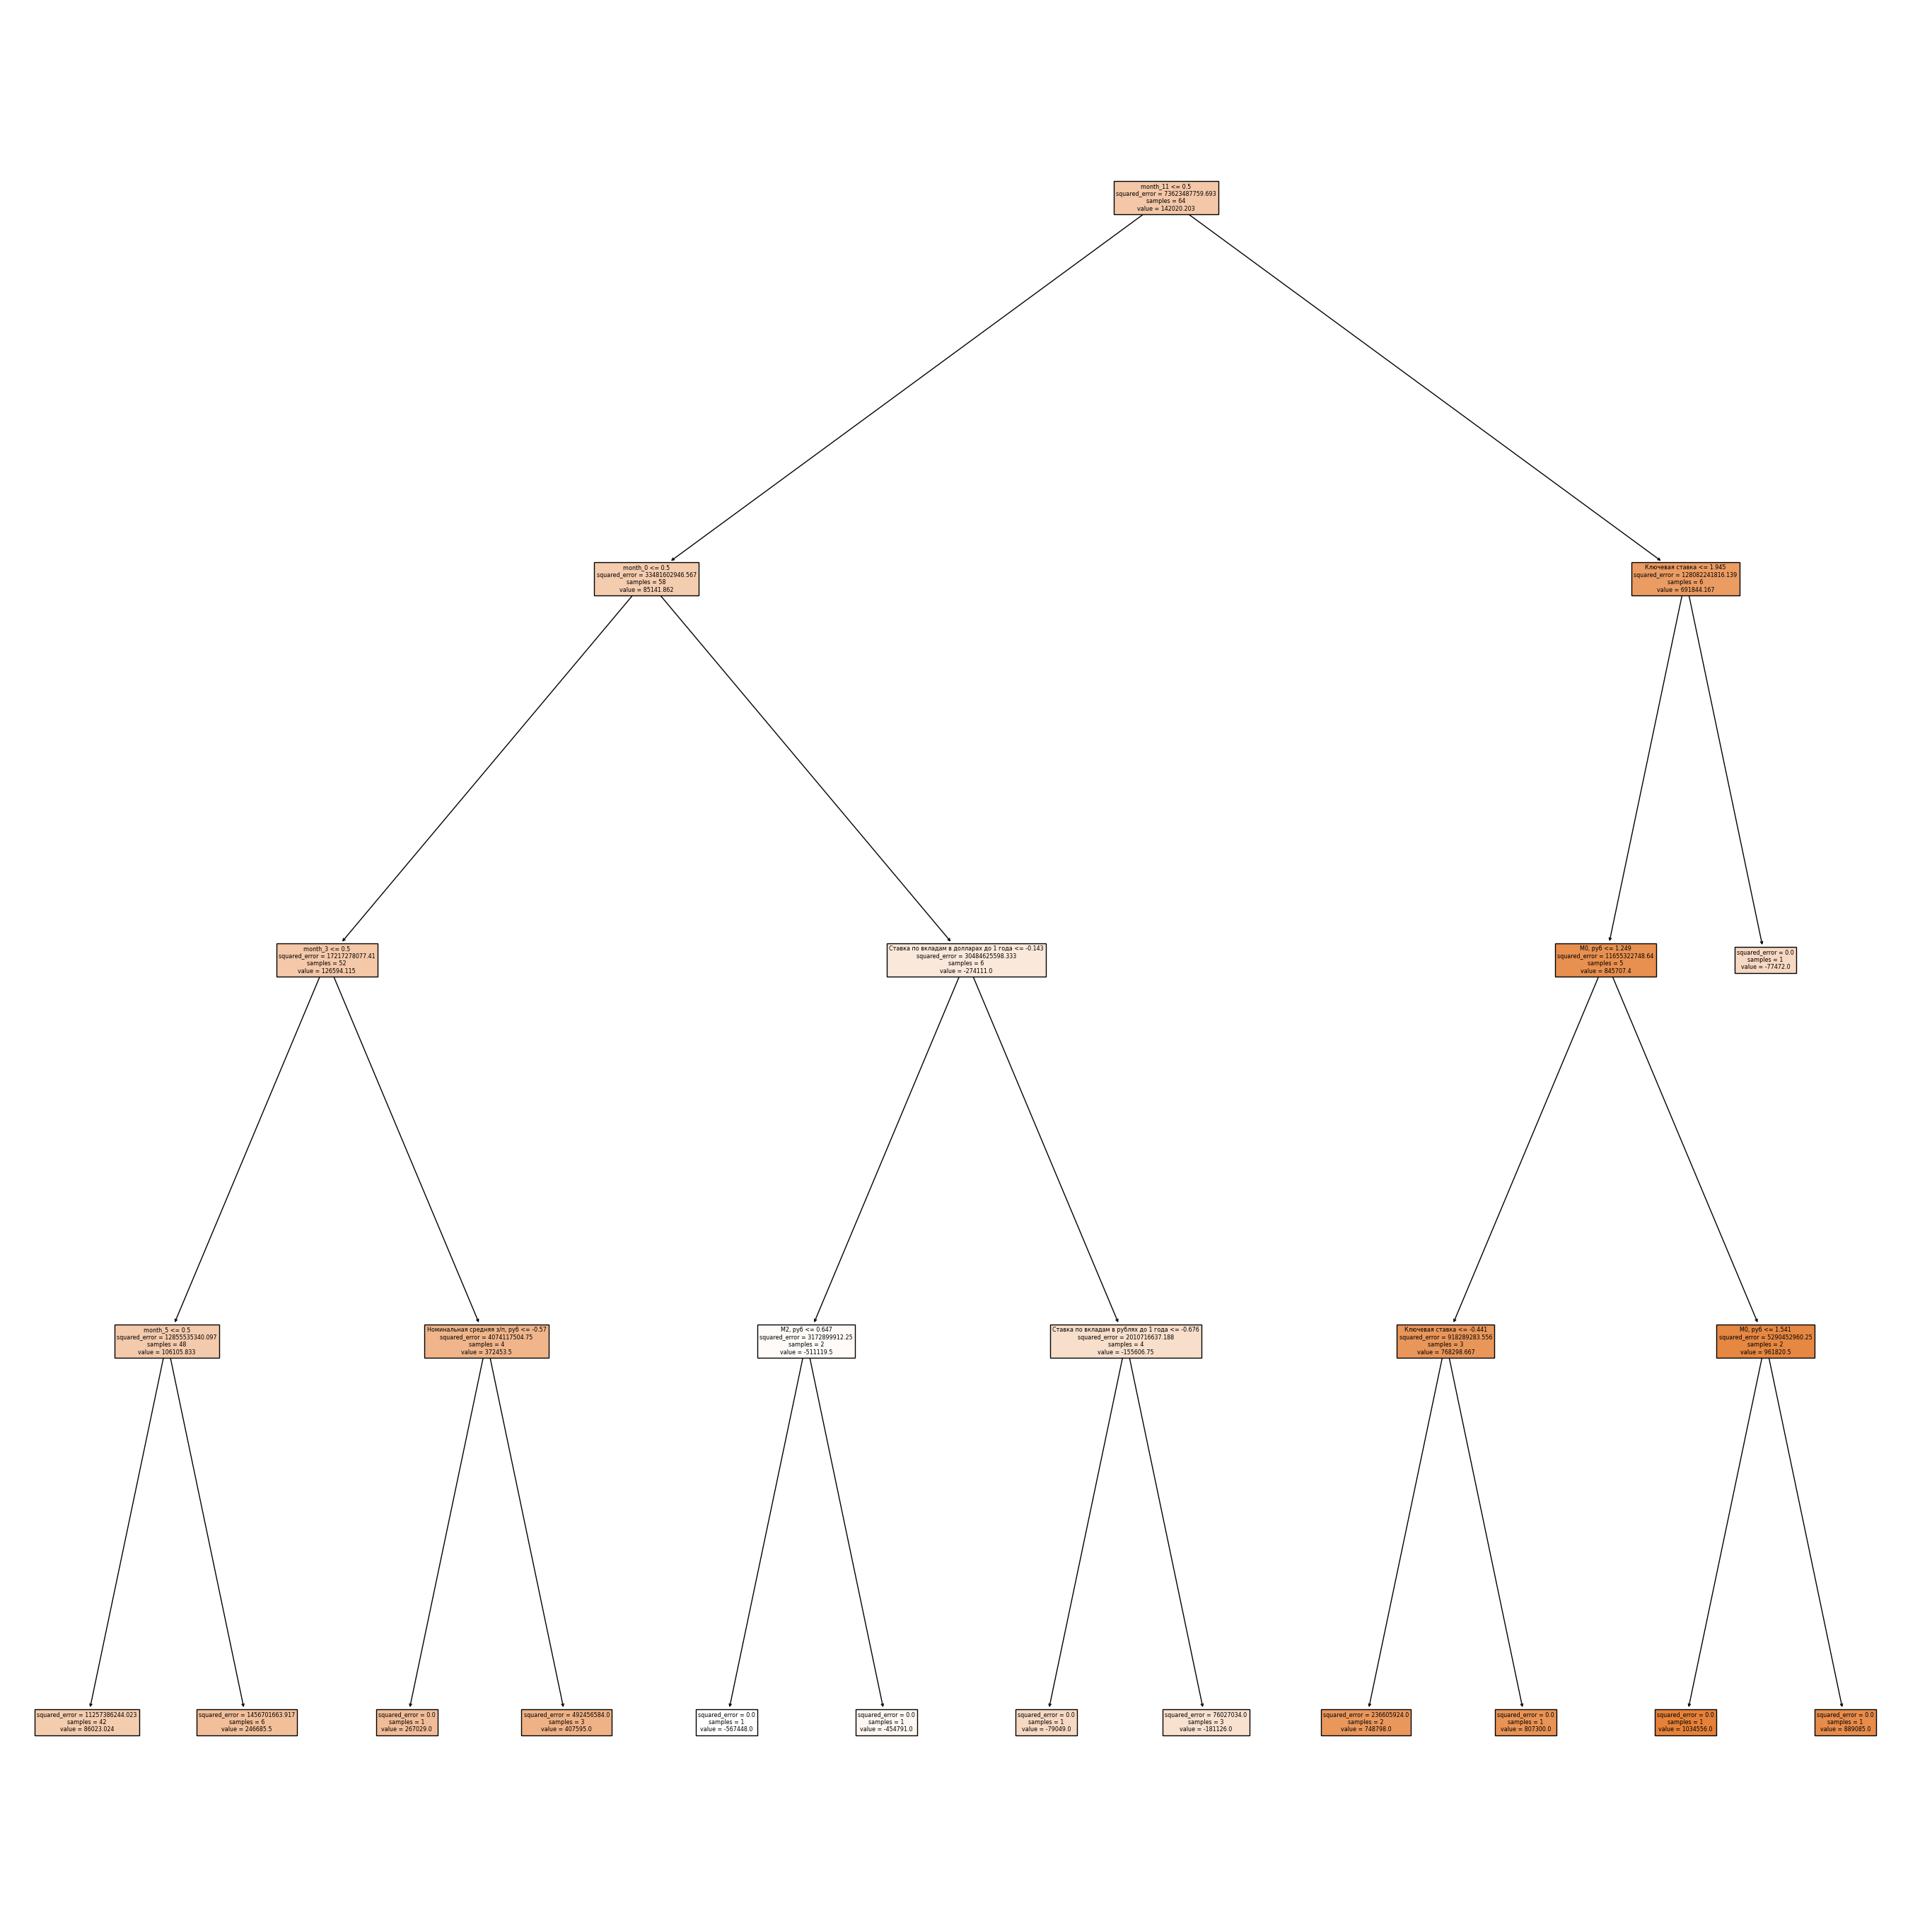

Результат подбора аримы модели: 
Порядок : ARIMA(1,0,1)(1,0,2)[12] intercept
Test MAE = 150501.8517
Test MSE = 72889550326.1114
Test RMSE = 269980.6481
Результат подбор SARIMAX модели:
                                               SARIMAX Results                                               
Dep. Variable:     Прирост вкладов физических лиц в рублях (млн руб)   No. Observations:                   64
Model:                           SARIMAX(1, 0, 1)x(1, 0, [1, 2], 12)   Log Likelihood                -853.409
Date:                                               Mon, 31 Oct 2022   AIC                           1744.818
Time:                                                       10:29:04   BIC                           1785.837
Sample:                                                            0   HQIC                          1760.977
                                                                - 64                                         
Covariance Type:                             

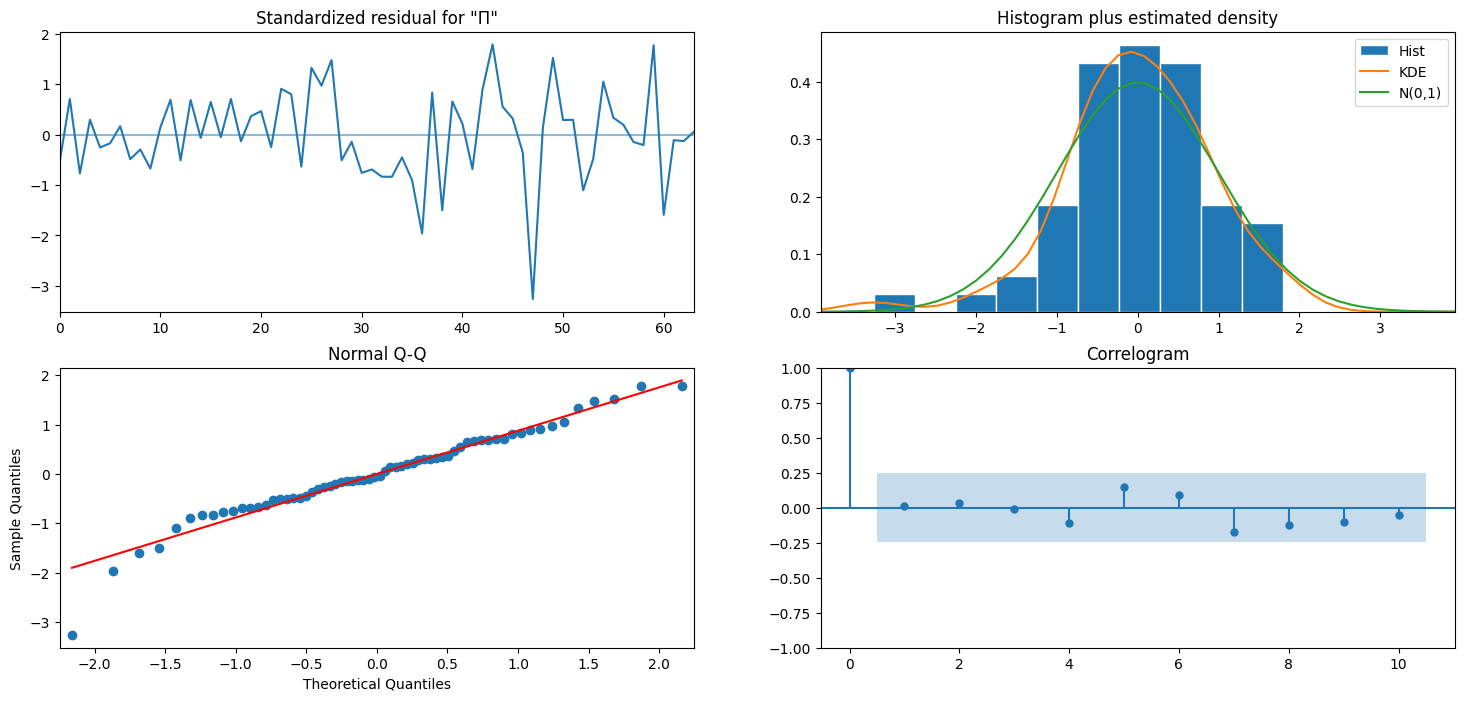

Test MAE = 184545.9492
Test MSE = 37336674275.4966
Test RMSE = 193227.0019
Таблица метрик
               model           RMSE
0  linear_regression  123754.568113
1   ridge_regression   97795.150898
2   lasso_regression  120016.592885
3              trees   98057.326823
4             SARIMA  269980.648059
5            SARIMAX  193227.001932
Лучшая модель: ridge_regression, ее ошибка: 97795.15089763995
Прогноз неизвестных значений:
[143834.91552921 179742.92677116 190734.12825893 216991.90033432
 207776.2801231  235769.27044298 198906.11548199 190634.91614275
 196526.40881933 200316.21761156 210511.04306131 343947.30078925]
CPU times: total: 12.8 s
Wall time: 13.2 s


In [65]:
%%time
model = Modelbank(df_1, train_ratio=0.9, regularization=True, independent_categorical_variable=['month', '2014'],
                  independent_numeric_variable=[
 'Доходность ОФЗ по сроку до 1 года',
 'Ключевая ставка',
 'Ставка по вкладам в долларах до 1 года',
 'Ставка по вкладам в рублях до\xa01\xa0года',
 'Нефть марки Юралс, долл./барр',
 'Индекс потребительских цен, ед.',
 'М0, руб',
 'М2, руб',
 'Курс доллара к рублю, руб',
 'Номинальная средняя з/п, руб',
 'trend'], target='Прирост вкладов физических лиц в рублях (млн руб)',dataframe_predict=df_2)
model.exploratory_analysis()
model.linear_regression()
model.trees()
model.sarima()
model.choose_best_model()
model.predict()

###  Вывод
Лучшая модель была выбрана Ridge регрессия. Плюсы данной модели, что она может экстраполировать наши данные (в отличие от Decision Trees). Также она отбирает важные признаки с помощью парамтра регуляризации. 

Наша модель смогла уловить сезонную составляющую (переменные month_i является значимой), политическую составляющую (переменная до 2014 года и после, тоже являются значимыми). Из количественных переменных наиболее существенный вклад оказывает 'Номинальная средняя з/п, руб', что не противоречит нашей логике.